Trigger time = 0.0s


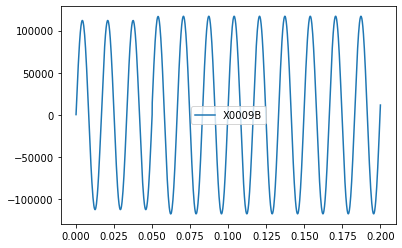

Falla CG
Distancia(pu): 1.7729826207104427
(0.48254603331254586+0.47742565858156977j)
(0.48254603331254586+0.47742565858156977j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8000831481277038
(0.4777007823040058+0.48449498674105457j)
(0.4777007823040058+0.48449498674105457j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8270161181255393
(0.47760543762047586+0.49152029672413455j)
(0.47760543762047586+0.49152029672413455j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8450322776450718
(0.48057850036076777+0.49614261615566135j)
(0.48057850036076777+0.49614261615566135j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8525673941497052
(0.48424733742567966+0.4979188723553998j)
(0.48424733742567966+0.4979188723553998j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.853469001376251
(0.487171505760191+0.49791667429181297j)
(0.487171505760191+0.49791667429181297j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8514899388021655


<ipython-input-52-20659d2feb04>:411: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure, axes = plt.subplots()


(0.4894156379114388+0.4914991559130499j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8269109626786375
(0.48812805870783915+0.4910693303595119j)
(0.48812805870783915+0.4910693303595119j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8301126946420287
(0.4870487920020431+0.49188326776072444j)
(0.4870487920020431+0.49188326776072444j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8349799614216598
(0.48713921064694643+0.4931972909429515j)
(0.48713921064694643+0.4931972909429515j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8369411226415462
(0.48823886371182595+0.4937838986684527j)
(0.48823886371182595+0.4937838986684527j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.8343980085292457
(0.48925069854237335+0.4931547227277422j)
(0.48925069854237335+0.4931547227277422j)
Dentro de la característica mho
Falla CG
Distancia(pu): 1.830218422988063
(0.48918400503400666+0.49202196345992044j)
(0.48918400503400666+0.49202196345992044j)
Dent

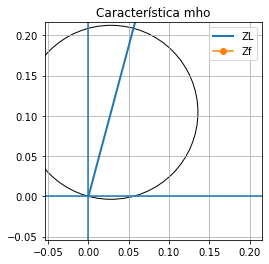

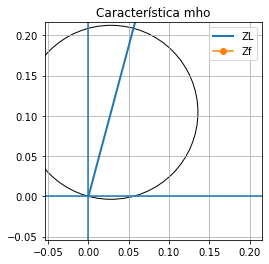

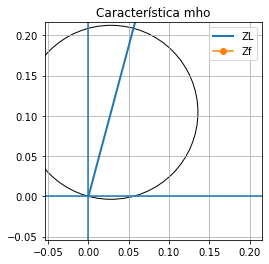

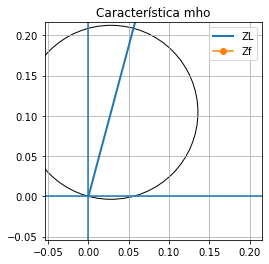

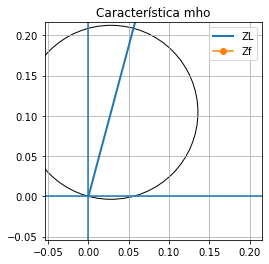

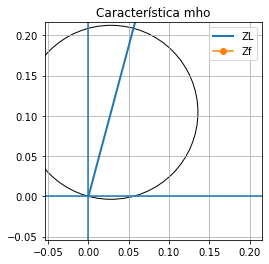

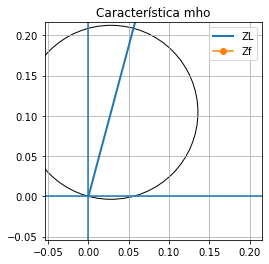

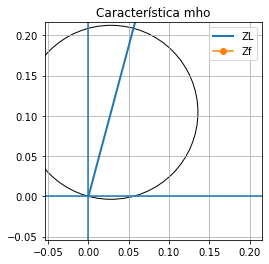

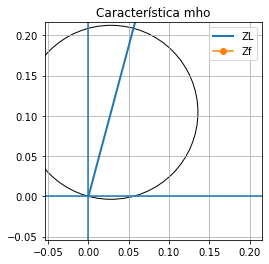

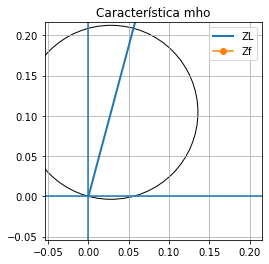

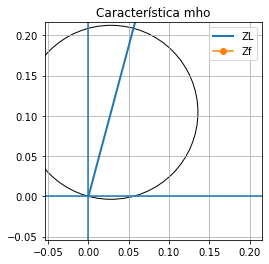

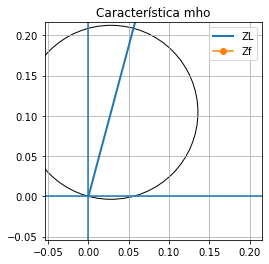

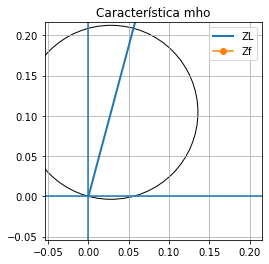

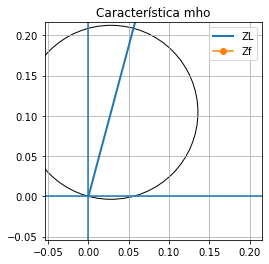

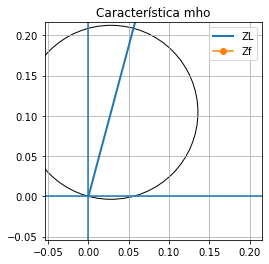

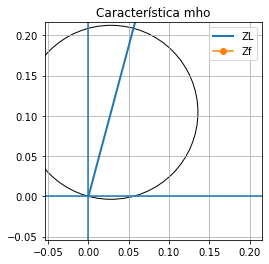

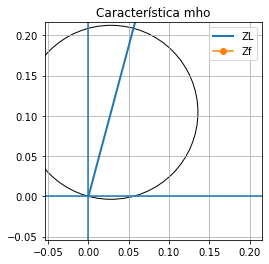

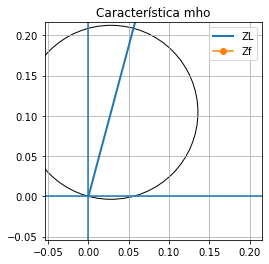

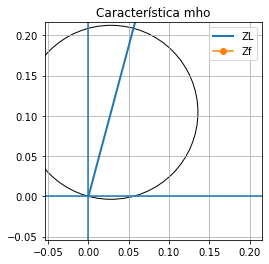

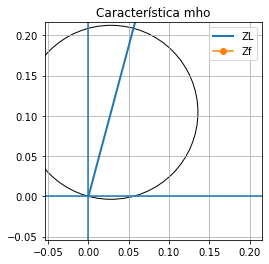

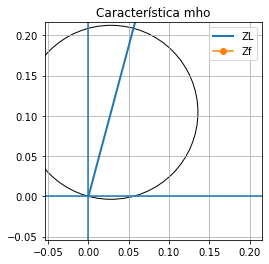

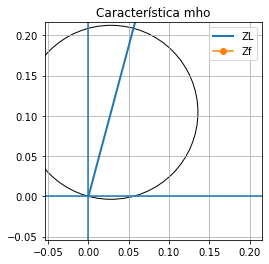

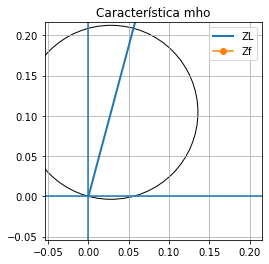

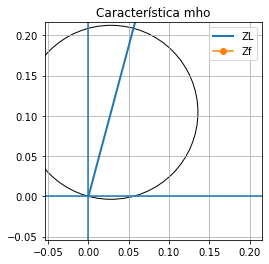

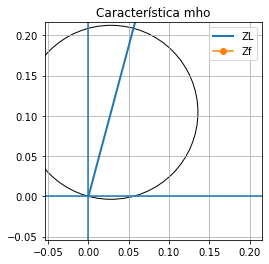

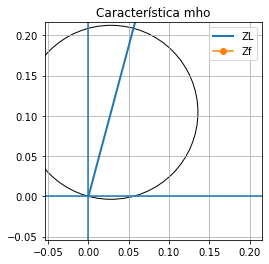

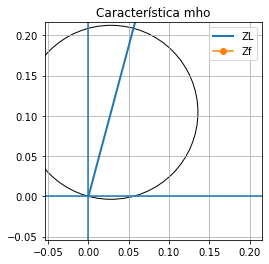

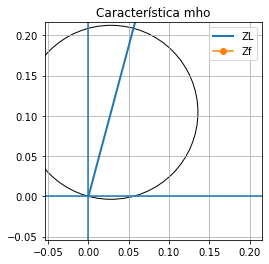

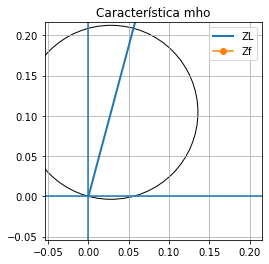

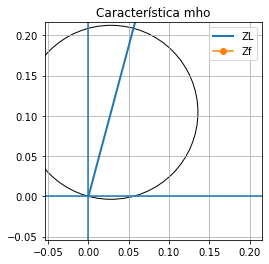

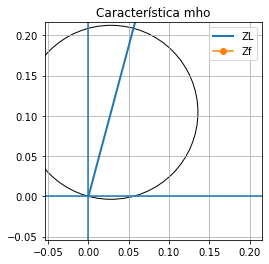

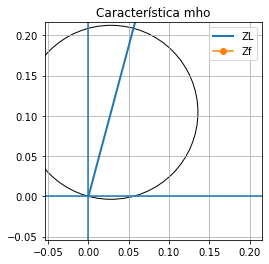

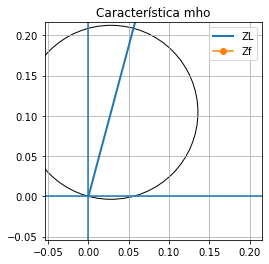

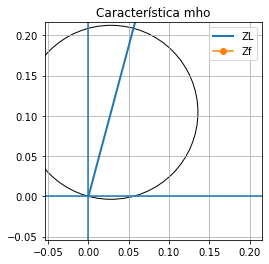

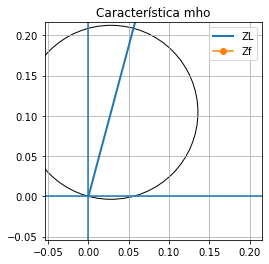

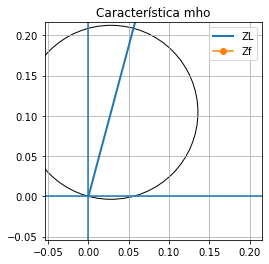

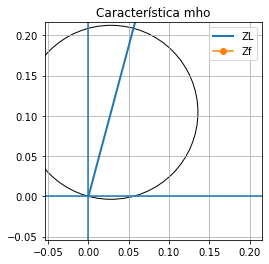

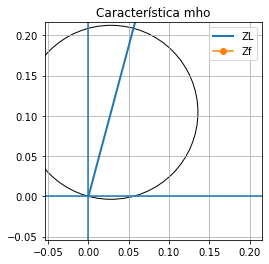

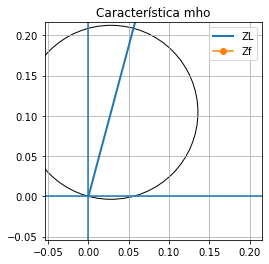

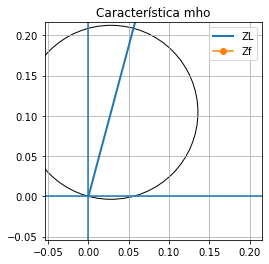

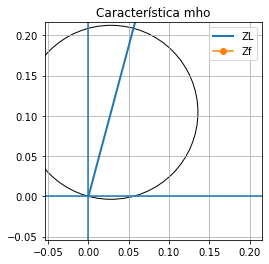

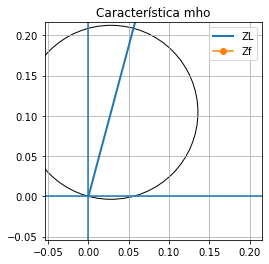

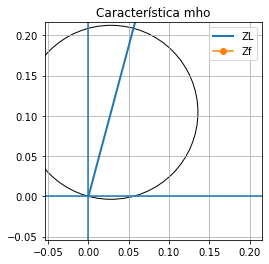

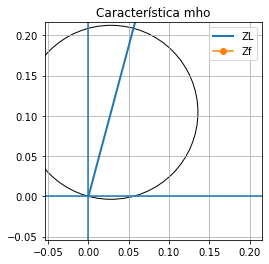

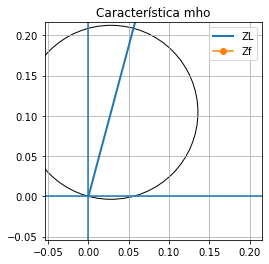

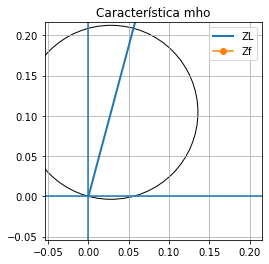

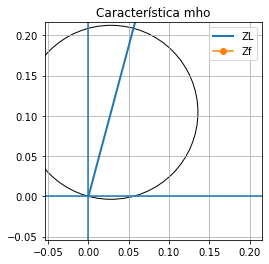

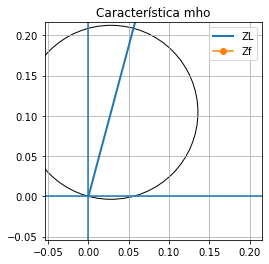

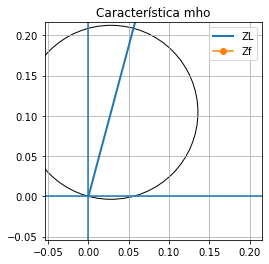

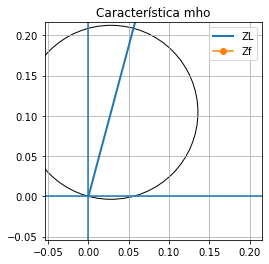

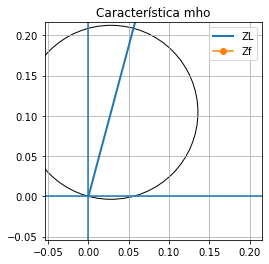

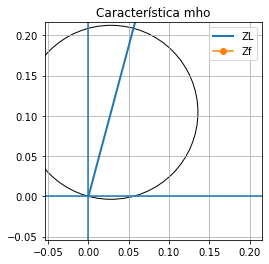

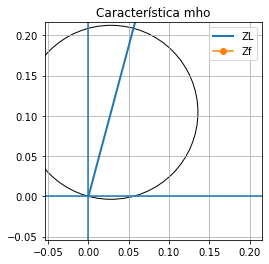

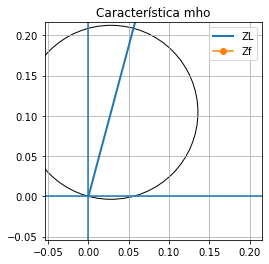

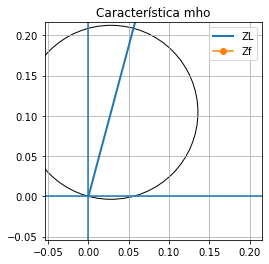

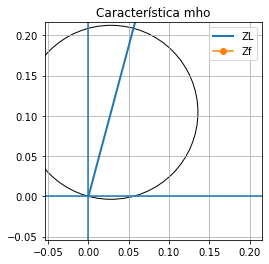

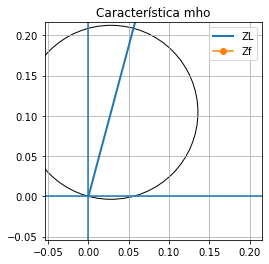

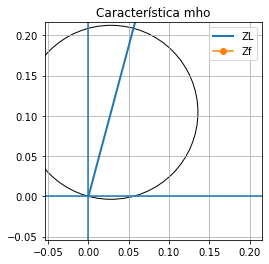

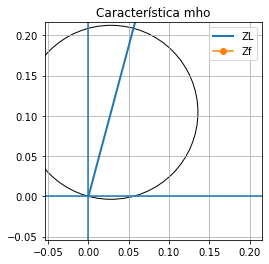

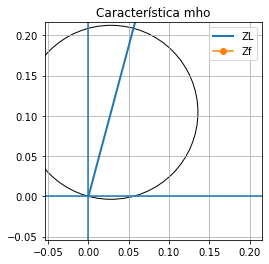

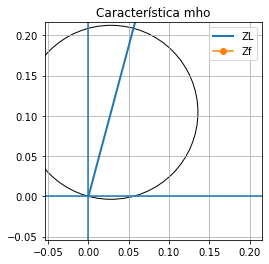

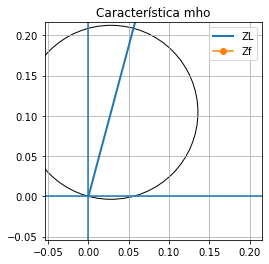

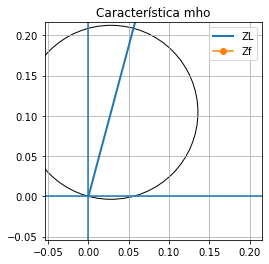

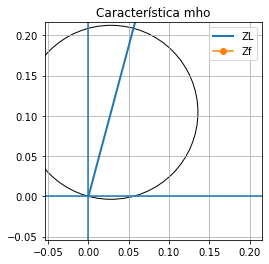

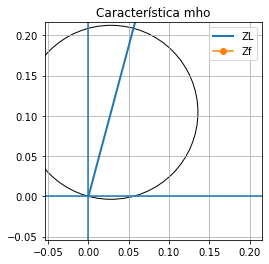

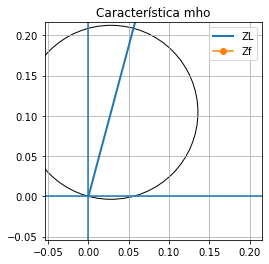

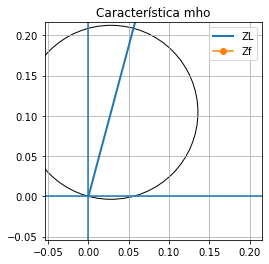

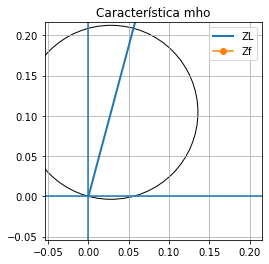

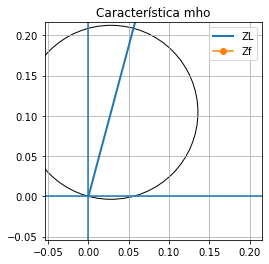

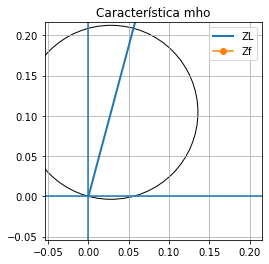

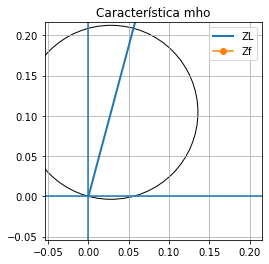

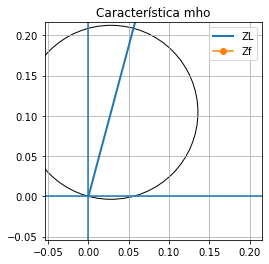

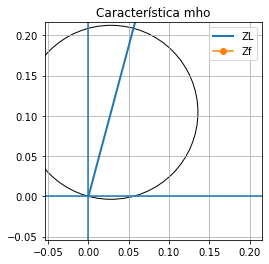

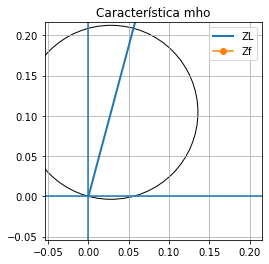

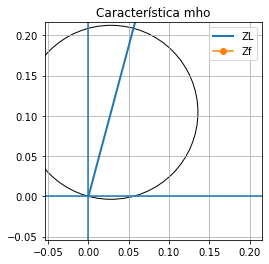

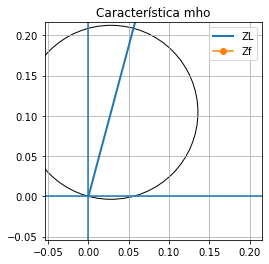

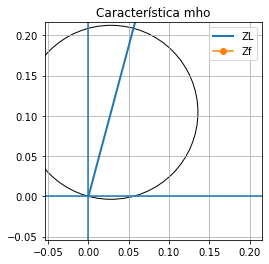

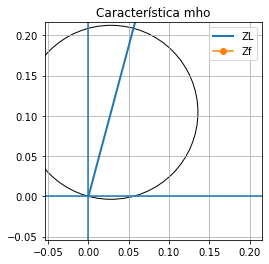

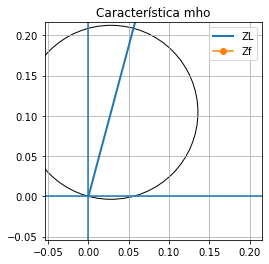

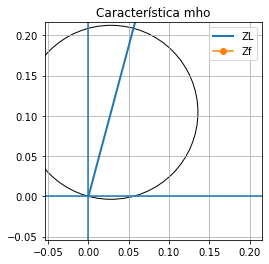

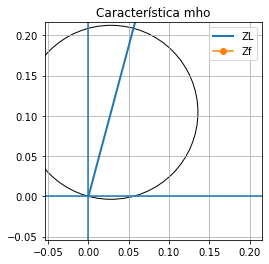

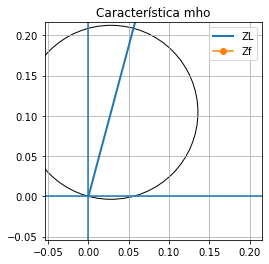

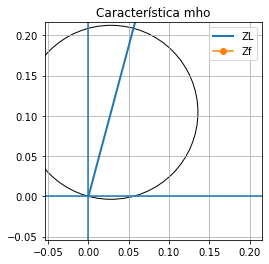

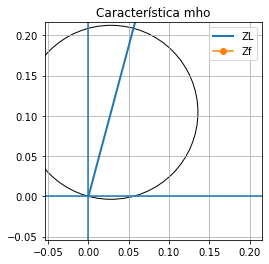

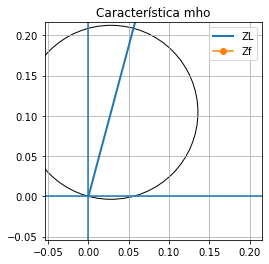

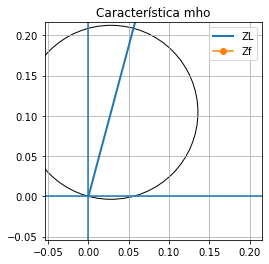

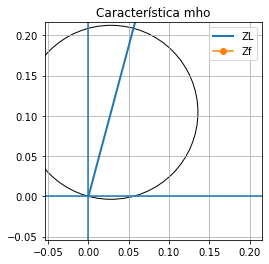

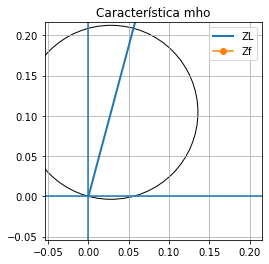

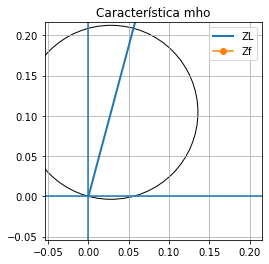

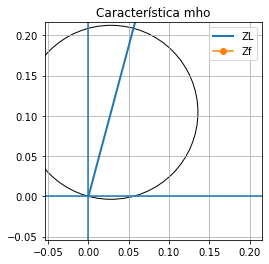

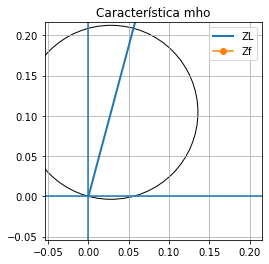

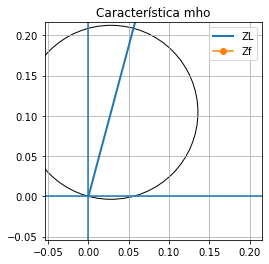

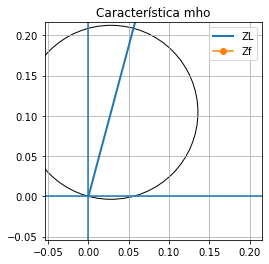

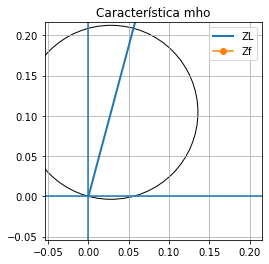

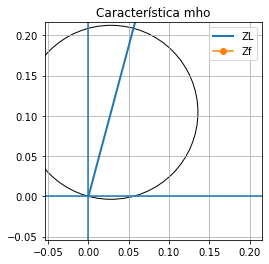

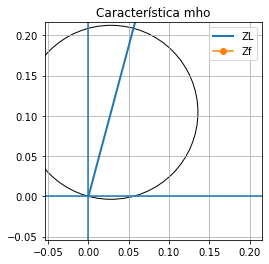

In [52]:
import matplotlib.pyplot as plt
from comtrade import Comtrade
import plotly.graph_objects as go
from antialising import Filtro
from array import array
from transformada import *
import secuencias
import numpy as np
import cmath

def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]


rec = Comtrade()
rec.load("sample_files/ATPmonoC0p98.cfg", "sample_files/ATPmonoC0p98.dat")
print("Trigger time = {}s".format(rec.trigger_time))

#Posiciones de las señales de voltaje y corriente en el COMTRADE
senal_I_a=0

senal_I_b=1

senal_I_c=2

senal_V_a=3

senal_V_b=4

senal_V_c=5

#Plot de la corriente de la fase a
plt.figure()
plt.plot(rec.time, rec.analog[senal_V_b])
plt.legend([rec.analog_channel_ids[senal_V_b]])
plt.show()

#Simulacion de ventaneo a 10 muestras por ciclo.
def Windowing(senal_a,senal_b,senal_c,rec,I_nominal,I_sc3_min,V_a,V_b,V_c,k0,z1l):
    data_a=rec.analog[senal_a]
    data_b=rec.analog[senal_b]
    data_c=rec.analog[senal_c]
    data_Va=rec.analog[V_a]
    data_Vb=rec.analog[V_b]
    data_Vc=rec.analog[V_c]
    t=rec.time
    fs = rec.cfg.sample_rates[0][0]       # sample rate 'analogo', Hz 
    fr=720#Frecuencia del relee
    r=(1/fr)//(1/fs)#Cantidad de muestras en 1 ciclo de una señal de 60Hz

    I_phase_r=np.empty((7,len(range(0,len(data_a),int(r)))))#[Ia;Ib;Ic;t;Va;Vb;Vc]

    for i in range(0,len(data_a),int(r)):#Creacion del array de muestras que toma el rele.
        I_phase_r[0][int(i/int(r))]=data_a[i]
        I_phase_r[1][int(i/int(r))]=data_b[i]
        I_phase_r[2][int(i/int(r))]=data_c[i]
        I_phase_r[3][int(i/int(r))]=t[i]
        I_phase_r[4][int(i/int(r))]=data_Va[i]
        I_phase_r[5][int(i/int(r))]=data_Vb[i]
        I_phase_r[6][int(i/int(r))]=data_Vc[i]
    s=1#numero de ciclos por ventana
    w=int(s*fr/60)#numero de muestras por ventana
  
    last_msg="Sin falla"#ultimo mensaje leido
    n=0#Cantidades sucesivas que se ha leido ese mensaje. Con 6 ventanas sucesivas (medio ciclo) reportando la misma falla, se activa el mecanismo de deteccion de fase fallada.
    k=0

    fault=False
    while(w+k<=len(I_phase_r[3])):#Por cada ventana se evalua la posibilidad de falla. De haber una, se determina que fases son las falladas.
        I_a=Espectro(I_phase_r[0][k:w+k],fr)
        I_b=Espectro(I_phase_r[1][k:w+k],fr)
        I_c=Espectro(I_phase_r[2][k:w+k],fr)
        k+=1
        Seq=secuencias.seq(I_a,I_b,I_c)#Referidos a la fase a
        
        I0=Seq.item((0,0))
        I1=Seq.item((1,0))
        I2=Seq.item((2,0))
       
        msg=Evaluar(I0,I1,I2,I_nominal,I_sc3_min)
        #print(msg)
        if msg=="Sin falla":
            n=0
        elif msg==last_msg:
            n+=1
        else:
            last_msg=msg
            n=1
            
        if n==8 or fault:
            fault=True
            v_a=Espectro(I_phase_r[4][k:w+k],fr)
            v_b=Espectro(I_phase_r[5][k:w+k],fr)
            v_c=Espectro(I_phase_r[6][k:w+k],fr)
            DefinePhase(last_msg,I_a,I_b,I_c,v_a,v_b,v_c,I2,I0,k0,z1l)

def DefinePhase(msg,Ia,Ib,Ic,Va,Vb,Vc,I2,I0,k0,Z1l):
    if msg=="Falla BG o AC":
        MHO_BG=abs(Vb/(Ib+k0*3*I0))
        MHO_AC=abs((Va-Vc)/(Ia-Ic))
        if MHO_BG>=MHO_AC:
            print("Falla AC")
            Vg=Vc-Va
            Ig=Ic-Ia
            Iseq=I2*cmath.rect(1,2*np.pi/3)#Referenciada a la fase sana (B)
            m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
            print("Distancia(pu): "+str(m))
            Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
            mho(Zest,Z1l)
        else:
            print("Falla BG")
            Vg=Vb
            Ig=Ib+k0*I0*3
            Iseq=I2*cmath.rect(1,2*np.pi/3)
            m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
            print("Distancia(pu): "+str(m))
            mho(Vg/Ig,Z1l)
    elif msg=="Falla AG o BC":
        MHO_AG=abs(Va/(Ia+k0*3*I0))
        MHO_BC=abs((Vb-Vc)/(Ib-Ic))
        if MHO_AG>=MHO_BC:
            print("Falla BC")
            Vg=Vb-Vc
            Ig=Ib-Ic
            Iseq=I2
            m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
            print("Distancia(pu): "+str(m))
            Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+I2))/(Ic+3*k0*I0))
            mho(Zest,Z1l)
        else:
            print("Falla AG")
            Vg=Va
            Ig=Ia+k0*I0*3
            Iseq=I2
            m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
            print("Distancia(pu): "+str(m))
            mho(Vg/Ig,Z1l)
            print("Mho: "+str(Vg/Ig))
    elif msg=="Falla CG o BA":
        MHO_CG=abs(Vc/(Ic+k0*3*I0))
        MHO_AB=abs((Va-Vb)/(Ia-Ib))
        if MHO_CG>=MHO_AB:
            print("Falla AB")
            Vg=Va-Vb
            Ig=Ia-Ib
            Iseq=I2*cmath.rect(1,-2*np.pi/3)
            m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
            print("Distancia(pu): "+str(m))
            Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
            mho(Zest,Z1l)
        else:
            print("Falla CG")
            Vg=Vc
            Ig=Ic+k0*I0*3
            Iseq=I2*cmath.rect(1,-2*np.pi/3)
            m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
            print("Distancia(pu): "+str(m))
            print(Vg/Ig)
            mho(Vg/Ig,Z1l)
    elif msg=="CG o alguna bifasica a tierra con Rf alto":
        #Calculo Rf
        Rcg=np.abs(np.imag(Vc*np.conjugate(Z1l*(Ic+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*(Ic+k0*3*I0))))
        Rab=np.abs(np.imag((Va-Vb)*np.conjugate(Z1l*((Ia-Ib)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ia-Ib)+k0*3*I0))))
        Rac=np.abs(np.imag((Va-Vc)*np.conjugate(Z1l*((Ia-Ic)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ia-Ic)+k0*3*I0))))
        Rcb=np.abs(np.imag((Vc-Vb)*np.conjugate(Z1l*((Ic-Ib)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ic-Ib)+k0*3*I0))))
        #calculo MHO
        Mab=np.abs((Va-Vb)/(Ia-Ib))
        Mac=np.abs((Va-Vc)/(Ia-Ic))
        Mcb=np.abs((Vc-Vb)/(Ic-Ib))

        if min(Mab,Mac,Mcb)==Mab:
            if Rcg<Rab:
                print("Falla c-g")
                Vg=Vc
                Ig=Ic+k0*I0*3
                Iseq=I2*cmath.rect(1,-2*np.pi/3)
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla a-b")
                Vg=Va-Vb
                Ig=Ia-Ib
                Iseq=I2*cmath.rect(1,-2*np.pi/3)
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
        elif min(Mab,Mac,Mcb)==Mac:
            if Rcg<Rac:
                print("Falla c-g")
                Vg=Vc
                Ig=Ic+k0*I0*3
                Iseq=I2*cmath.rect(1,-2*np.pi/3)
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla a-c")       
                Vg=Vc-Va
                Ig=Ic-Ia
                Iseq=I2*cmath.rect(1,2*np.pi/3)#Referenciada a la fase sana (B)
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
        else:
            if Rcg<Rcb:
                print("Falla c-g")
                Vg=Vc
                Ig=Ic+k0*I0*3
                Iseq=I2*cmath.rect(1,-2*np.pi/3)
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla c-b")
                Vg=Vb-Vc
                Ig=Ib-Ic
                Iseq=I2
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+I2))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
    elif msg=="BG o alguna bifasica a tierra con Rf alto":
        #Calculo Rf
        Rbg=np.abs(np.imag(Vb*np.conjugate(Z1l*(Ib+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*(Ib+k0*3*I0))))
        Rab=np.abs(np.imag((Va-Vb)*np.conjugate(Z1l*((Ia-Ib)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ia-Ib)+k0*3*I0))))
        Rac=np.abs(np.imag((Va-Vc)*np.conjugate(Z1l*((Ia-Ic)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ia-Ic)+k0*3*I0))))
        Rcb=np.abs(np.imag((Vc-Vb)*np.conjugate(Z1l*((Ic-Ib)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ic-Ib)+k0*3*I0))))
        #calculo MHO
        Mab=np.abs((Va-Vb)/(Ia-Ib))
        Mac=np.abs((Va-Vc)/(Ia-Ic))
        Mcb=np.abs((Vc-Vb)/(Ic-Ib))

        if min(Mab,Mac,Mcb)==Mab:
            if Rbg<Rab:
                print("Falla b-g")
                Vg=Vb
                Ig=Ib+k0*I0*3
                Iseq=I2*cmath.rect(1,2*np.pi/3)
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla a-b")
                Vg=Va-Vb
                Ig=Ia-Ib
                Iseq=I2*cmath.rect(1,-2*np.pi/3)
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
        elif min(Mab,Mac,Mcb)==Mac:
            if Rbg<Rac:
                print("Falla b-g")
                Vg=Vb
                Ig=Ib+k0*I0*3
                Iseq=I2*cmath.rect(1,2*np.pi/3)
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla a-c")
                Vg=Vc-Va
                Ig=Ic-Ia
                Iseq=I2*cmath.rect(1,2*np.pi/3)#Referenciada a la fase sana (B)
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
        else:
            if Rbg<Rcb:
                print("Falla b-g")
                Vg=Vb
                Ig=Ib+k0*I0*3
                Iseq=I2*cmath.rect(1,2*np.pi/3)
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla c-b")
                Vg=Vb-Vc
                Ig=Ib-Ic
                Iseq=I2
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+I2))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
    elif msg=="AG o alguna bifasica a tierra con Rf alto":
        #Calculo Rf
        Rag=np.abs(np.imag(Va*np.conjugate(Z1l*(Ia+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*(Ia+k0*3*I0))))
        Rab=np.abs(np.imag((Va-Vb)*np.conjugate(Z1l*((Ia-Ib)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ia-Ib)+k0*3*I0))))
        Rac=np.abs(np.imag((Va-Vc)*np.conjugate(Z1l*((Ia-Ic)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ia-Ic)+k0*3*I0))))
        Rcb=np.abs(np.imag((Vc-Vb)*np.conjugate(Z1l*((Ic-Ib)+k0*3*I0)))/np.imag(1.5*(I2+I0)*np.conjugate(Z1l*((Ic-Ib)+k0*3*I0))))
        #calculo MHO
        Mab=np.abs((Va-Vb)/(Ia-Ib))
        Mac=np.abs((Va-Vc)/(Ia-Ic))
        Mcb=np.abs((Vc-Vb)/(Ic-Ib))

        if min(Mab,Mac,Mcb)==Mab:
            if Rag<Rab:
                print("Falla a-g")
                Vg=Va
                Ig=Ia+k0*I0*3
                Iseq=I2
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla a-b")
                Vg=Va-Vb
                Ig=Ia-Ib
                Iseq=I2*cmath.rect(1,-2*np.pi/3)
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
        elif min(Mab,Mac,Mcb)==Mac:
            if Rag<Rac:
                print("Falla a-g")
                Vg=Va
                Ig=Ia+k0*I0*3
                Iseq=I2
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla a-c")
                Vg=Vc-Va
                Ig=Ic-Ia
                Iseq=I2*cmath.rect(1,2*np.pi/3)#Referenciada a la fase sana (B)
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+Iseq))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
        else:
            if Rag<Rcb:
                print("Falla a-g")
                Vg=Va
                Ig=Ia+k0*I0*3
                Iseq=I2
                m=np.imag(Vg*np.conjugate(Iseq))/np.imag(Z1l*Ig*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m))
                print(Vg/Ig)
                mho(Vg/Ig,Z1l)
            else:
                print("Falla c-b")
                Vg=Vb-Vc
                Ig=Ib-Ic
                Iseq=I2
                m=np.imag(Vg*1j*np.conjugate(Iseq))/np.imag(Z1l*Ig*1j*np.conjugate(Iseq))
                print("Distancia(pu): "+str(m),Rcb)
                Zest=m*Z1l+np.abs(Rcb*(1.5*(I0+I2))/(Ic+3*k0*I0))
                mho(Zest,Z1l)
    elif msg=="Falla trifasica":
        print("ABC")
        Vg=Va-Vb
        Ig=Ia-Ib
        m=np.imag(Vg/Ig)/np.imag(Z1l)
        print("Distancia(pu): "+str(m))
        mho(Vg/Ig,Z1l)
    else:
        print("Sin falla")   

#Determina si hay falla y da una aproximacion de cuales pueden ser las fases falladas.
def Evaluar(I0,I1,I2,I_nominal,I_sc3_min):
    #print(np.abs(I0),np.abs(I2),np.abs(I1))
    #print(I0,I1,I2)
    if(np.abs(I0)/np.abs(I1)<0.005 and np.abs(I2)/np.abs(I1)<0.005 and np.abs(I1)>=I_sc3_min):
            return "Falla trifasica"
    elif((np.angle(I2,True))%360<=(np.angle(I0,True)-90)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-150)%360):
            return "Falla BG o AC"
    elif((np.angle(I2,True))%360<=(np.angle(I0,True)+30)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-30)%360):
            return "Falla AG o BC"
    elif((np.angle(I2,True))%360<=(np.angle(I0,True)+150)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+90)%360):
            return "Falla CG o BA"
    elif(((np.angle(I2,True))%360<=(np.angle(I0,True)+60)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+30)%360) or (((np.angle(I2,True))%360<=(np.angle(I0,True)-30)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-60)%360))):
            return "AG o alguna bifasica a tierra con Rf alto"
    elif(((np.angle(I2,True))%360<=(np.angle(I0,True)-60)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-90)%360) or (((np.angle(I2,True))%360<=(np.angle(I0,True)-150)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-180)%360))):
            return "BG o alguna bifasica a tierra con Rf alto"
    elif(((np.angle(I2,True))%360<=(np.angle(I0,True)+90)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+60)%360) or (((np.angle(I2,True))%360<=(np.angle(I0,True)+180)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+150)%360))):
            return "CG o alguna bifasica a tierra con Rf alto"
    else: 
            return "Sin falla"

#Retorna el fasor de 60Hz de la señal dada como input
def Espectro(data,fs):
    #Filtro pasa bajas
    cutoff = (fs-60)/3      # desired cutoff frequency of the filter, Hz
    order = 2

    y=Filtro(fs,order,cutoff,data)
    
    #Transformada
    N=len(data)
    Tf=1/fs
    SOL=FFT(y)
    SOL_f=FFT_f(N,Tf)

    SOL_abs=2.0/N * np.abs(SOL[0:N//2])
    SOL_angle=np.angle(SOL)[0:N//2]
    i=closest(SOL_f,60)
    j=np.where(SOL_f==i)#Index con el fasor de 60Hz
    #plt.polar([0,SOL_angle[j]],[0,SOL_abs[j]],marker='.')

    return cmath.rect(SOL_abs[j],SOL_angle[j])

#Valores dados
I_nominal=800
I_sc3_min=27370#pico
Z0l=(0.283+0.8226j)
Z1l=(0.06988+0.2608j)
K0=((1/3)*(Z0l/Z1l-1))

def mho(z,zl):
    figure, axes = plt.subplots()
    print(z)
    #Este codigo me lo paso mi compañero Warley Sequeda.


    # Coordenadas de Z(measured) = a + 1j*b
    a = np.real(zl)
    b = np.imag(zl)

    # Coordenadas de Zr = x + 1j*y
    x = np.real(z)
    y = np.imag(z)
    theta = np.arctan(y/x)

    # Hallamos el radio del círculo y sus coordenadas
    radio = np.abs(zl)*0.8/2
    x1 = a*0.8/2
    y1 = b*0.8/2

    # Gráficamos el circulo
    draw_circle = plt.Circle((x1, y1), radio,fill=False)
    axes.set_aspect(1)
    axes.add_artist(draw_circle)

    # Coordenadas de Zr
    x_plot = [0, a]
    y_plot = [0, b]

    # Graficamos Zr
    plt.plot(x_plot, y_plot, linewidth=2)

    # Graficamos Z (measured)
    plt.plot([x],[y],marker ="o")

    # Comparamos si está dentro o fuera de la característica mho
    Zr = x + 1j*y
    Z = a + 1j*b

    comparador = ((Zr - Z)*np.conj(Z)).real

    # Propiedades del Gráfico
    plt.grid(True)
    plt.title('Característica mho')
    plt.legend(['ZL','Zf'])
    if(comparador > 0 ):
        print("Dentro de la característica mho")
        plt.xlim([-0.5*radio,radio*2 ])
        plt.ylim([-0.5*radio,radio*2 ])
        # Graficamos los ejes 
        plt.hlines(y=0, xmin= -0.5*radio, xmax=radio*2)
        plt.vlines(x=0, ymin= -0.5*radio, ymax=radio*2)
    else:
        print("Fuera de la característica mho")
        if (abs(a) > abs(b)):
            max = abs(a)
        else:
            max = abs(b)
            print(max, a,b)
            plt.xlim([-max - 0.5*radio ,max + radio*2])
            plt.ylim([-max - 0.5*radio ,max + radio*2])
            # Graficamos los ejes 
            plt.hlines(y=0, xmin= -max -0.5*radio, xmax = max + radio*2)
            plt.vlines(x=0, ymin= -max -0.5*radio, ymax = max + radio*2)

Windowing(senal_I_a,senal_I_b,senal_I_c,rec,I_nominal,I_sc3_min,senal_V_a,senal_V_b,senal_V_c,K0,Z1l)




